In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass

Mounted at /content/drive


In [ ]:
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

In [ ]:
# Path to your HDF5 file
hdf5_file_path = '/content/drive/My Drive/IS4242/processed_data/preprocessed_images_h5'

# Open the HDF5 file
with h5py.File(hdf5_file_path, 'r') as hf:
    # Access the dataset containing images
    images = hf['preprocessed_images'][:]

# Now 'images' variable contains your array of images
# You can use it as needed
print(f"Loaded HDF5 file with images of shape: {images.shape}")

Loaded HDF5 file with images of shape: (857, 128, 128, 3)


In [ ]:
# Path to your HDF5 file
hdf5_file_path = '/content/drive/My Drive/IS4242/processed_data/labels_h5'

# Open the HDF5 file
with h5py.File(hdf5_file_path, 'r') as hf:
    # Access the dataset containing images
    labels = hf['labels'][:]

# Now 'images' variable contains your array of images
# You can use it as needed
print(f"Loaded HDF5 file with labels of shape: {labels.shape}")

Loaded HDF5 file with labels of shape: (857,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(685, 128, 128, 3)
(172, 128, 128, 3)
(685,)
(172,)


In [ ]:
# flatten X_train and X_test to 2d array
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
print(X_train_flat.shape)
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3])
print(X_test_flat.shape)

(685, 49152)
(172, 49152)


In [ ]:
# decode labels
y_train_decode = [label.decode() for label in y_train]
y_test_decode = [label.decode() for label in y_test]
print(np.unique(y_train_decode))

['France grn' 'Fuji' 'USA Envy' 'USA Koru']


In [ ]:
# Baseline model
rf_classifier = RandomForestClassifier(random_state=10)
rf_classifier.fit(X_train_flat, y_train_decode)
train_accuracy = rf_classifier.score(X_train_flat, y_train_decode)
print("Training Accuracy:", train_accuracy)
test_accuracy = rf_classifier.score(X_test_flat, y_test_decode)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.8081395348837209


In [ ]:
predicted_y = rf_classifier.predict(X_test_flat)
print(classification_report(y_test_decode, predicted_y))

              precision    recall  f1-score   support

  France grn       0.93      0.93      0.93        27
        Fuji       0.71      0.93      0.81        54
    USA Envy       0.85      0.76      0.80        59
    USA Koru       0.86      0.59      0.70        32

    accuracy                           0.81       172
   macro avg       0.84      0.80      0.81       172
weighted avg       0.82      0.81      0.81       172



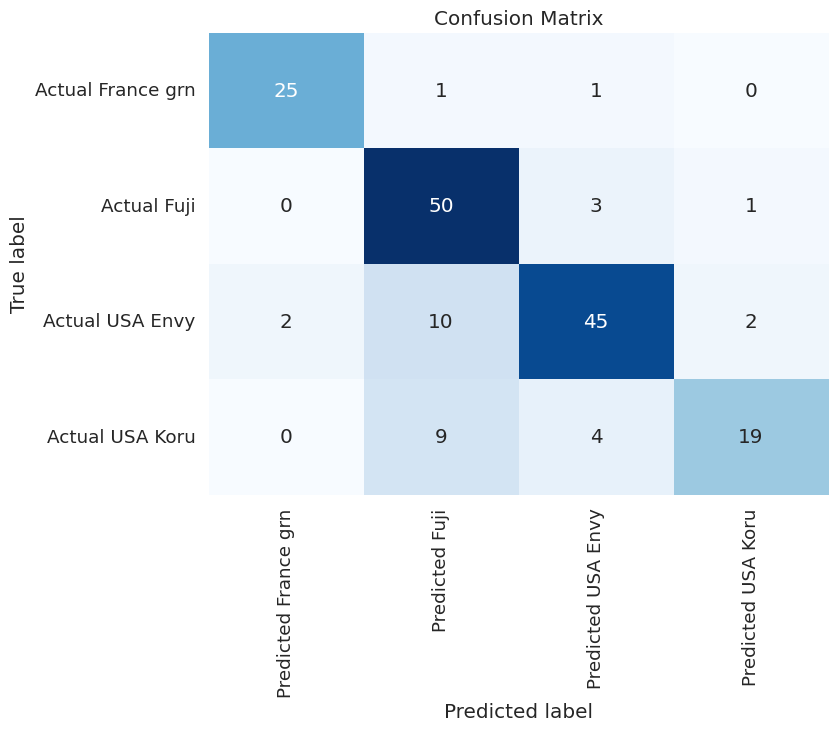

In [ ]:
conf_matrix = confusion_matrix(y_test_decode, predicted_y)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted France grn', 'Predicted Fuji', 'Predicted USA Envy', 'Predicted USA Koru'],
            yticklabels=['Actual France grn', 'Actual Fuji', 'Actual USA Envy', 'Actual USA Koru'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200], #default 100
    'min_samples_split': [2, 5, 10], #default 2
    'max_depth': [None, 10, 20], #default None
    'max_features': ['sqrt', 'log2'], #default sqrt
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=1)
grid_search.fit(X_train_flat, y_train_decode)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
train_accuracy = best_model.score(X_train_flat, y_train_decode)
print("Training Accuracy:", train_accuracy)
test_accuracy = best_model.score(X_test_flat, y_test_decode)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.8081395348837209


In [ ]:
predicted_y = best_model.predict(X_test_flat)
print(classification_report(y_test_decode, predicted_y))

              precision    recall  f1-score   support

  France grn       0.96      0.93      0.94        27
        Fuji       0.72      0.93      0.81        54
    USA Envy       0.82      0.76      0.79        59
    USA Koru       0.86      0.59      0.70        32

    accuracy                           0.81       172
   macro avg       0.84      0.80      0.81       172
weighted avg       0.82      0.81      0.81       172



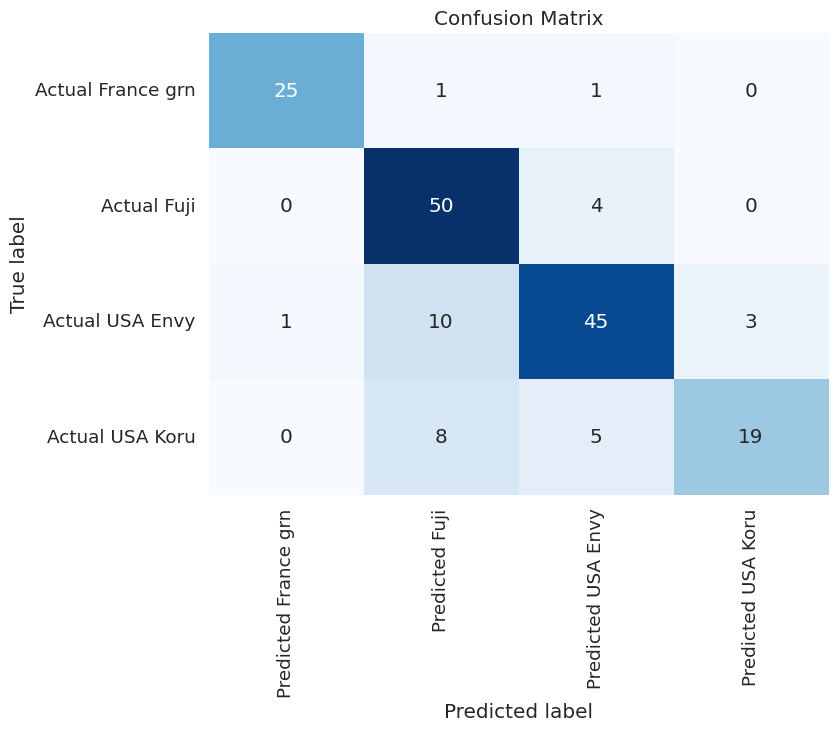

In [ ]:
conf_matrix = confusion_matrix(y_test_decode, predicted_y)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted France grn', 'Predicted Fuji', 'Predicted USA Envy', 'Predicted USA Koru'],
            yticklabels=['Actual France grn', 'Actual Fuji', 'Actual USA Envy', 'Actual USA Koru'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_test.shape

(172, 128, 128, 3)

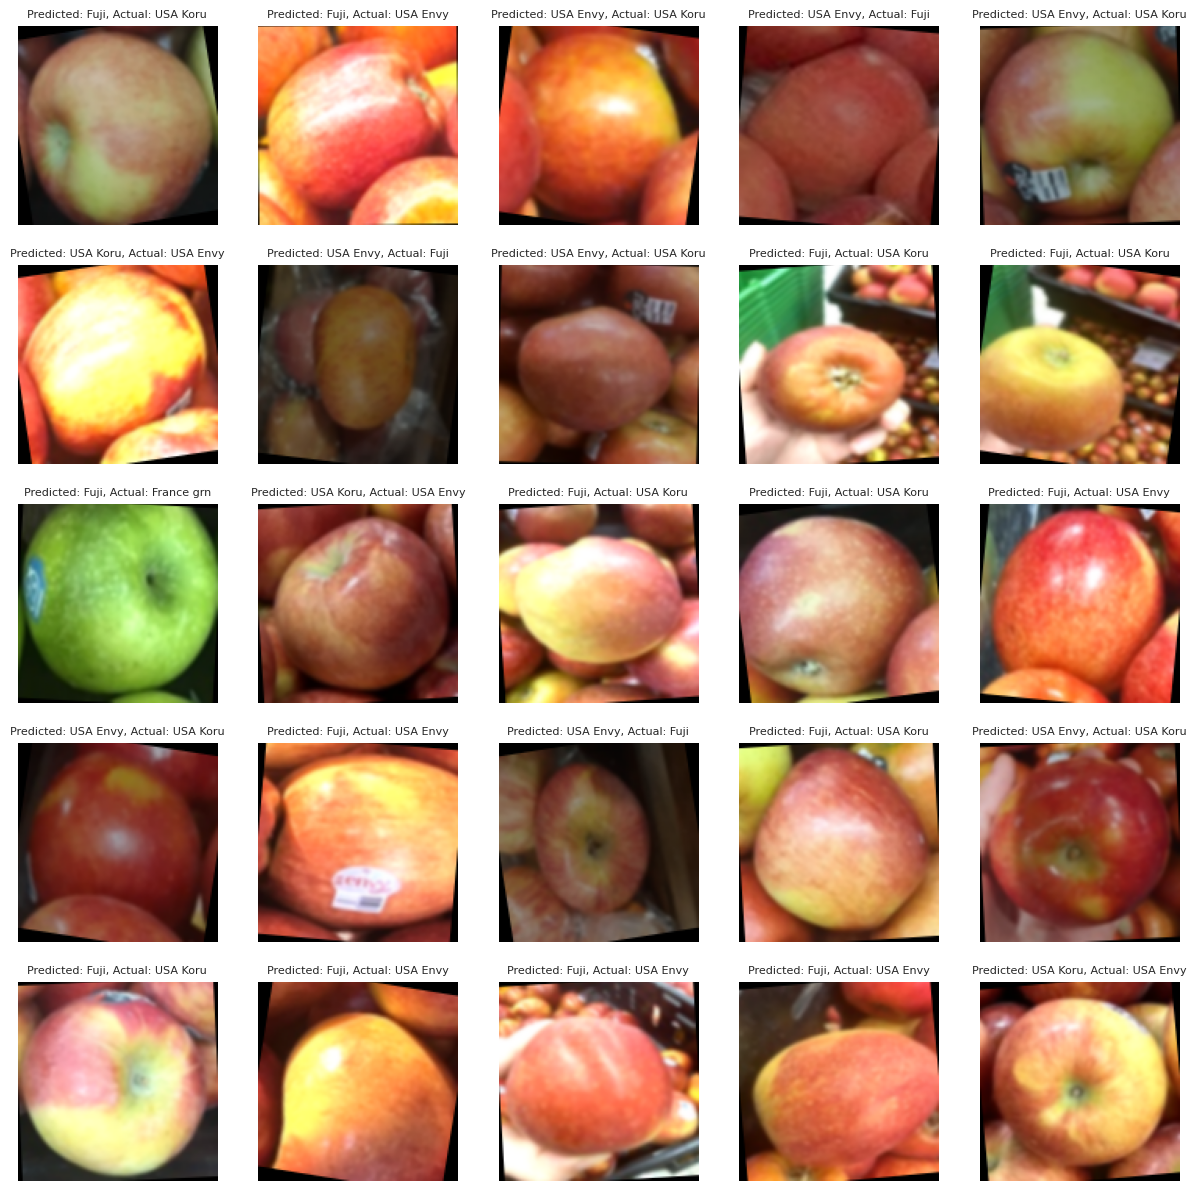

In [ ]:
misclassified_indices = np.where(y_test_decode != predicted_y)[0]


# Output the wrongly classified images
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[index][:,:,::-1])
    plt.title(f'Predicted: {predicted_y[index]}, Actual: {y_test_decode[index]}', fontdict={'fontsize': 8})
    plt.axis('off')
plt.show()